In [17]:
# ISA 530: Final Project
# Quantifying the Predictive Power of Biological vs. Environmental Features in Health Outcomes 
# Supervised Learning 
# Carly Carroll

### Import Libraries

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score, accuracy_score, f1_score, 
                             roc_auc_score, confusion_matrix, classification_report, precision_recall_curve,
                             balanced_accuracy_score)
import warnings
warnings.filterwarnings("ignore")

### Prepare Data

In [14]:
# paths to data
base_path = "/Users/carlycarroll/Desktop/MIDUS/Data"
long_path = f"{base_path}/MIDUS_twins_long.csv"
diffs_path = f"{base_path}/MIDUS_twins_diffs.csv"

# load datasets
long  = pd.read_csv(long_path)
diffs = pd.read_csv(diffs_path)

display(long.head())
display(diffs.head())

,M2ID,wave,M2FAMNUM,SAMPLMAJ,ZYGCAT,SRH,HYPERTEN,DIABETES,ASTHMA,DEPRESS,BMI,EDUC,HHINCOME,SMOKING,ALCOHOL,EXERCISE,MARITAL,AGE,SEX
0,10005.0,M1,120803.0,3.0,3.0,9.0,1.0,2.0,2.0,2.0,26.507816,5.0,2.0,2.0,32.0,1.0,NaN,NaN,NaN
1,10006.0,M1,120772.0,3.0,2.0,8.0,2.0,2.0,2.0,1.0,26.891987,6.0,2.0,2.0,21.0,2.0,NaN,NaN,NaN
2,10010.0,M1,120378.0,3.0,3.0,6.0,2.0,2.0,2.0,1.0,23.056296,3.0,2.0,1.0,18.0,2.0,3.0,NaN,NaN
3,10015.0,M1,120805.0,3.0,1.0,7.0,2.0,2.0,2.0,1.0,31.601253,5.0,NaN,1.0,19.0,2.0,3.0,NaN,NaN
4,10030.0,M1,120243.0,3.0,1.0,8.0,2.0,2.0,2.0,2.0,25.584351,8.0,2.0,2.0,24.0,2.0,1.0,NaN,NaN


,M2FAMNUM,wave,d_BMI,d_DEPRESS,d_HYPERTEN,d_DIABETES,d_ASTHMA,d_EDUC,d_HHINCOME,d_SMOKING,d_ALCOHOL,d_EXERCISE,d_AGE,d_MARITAL,d_SEX,d_SRH,ZYGCAT
0,120002.0,M1,-6.799214,1.0,0.0,0.0,0.0,3.0,0.0,NaN,-18.0,0.0,NaN,1.0,NaN,3.0,3.0
1,120002.0,M2,-4.734714,1.0,1.0,1.0,1.0,3.0,0.0,NaN,-33.0,0.0,-1.0,1.0,NaN,4.0,NaN
2,120003.0,M1,7.966034,-1.0,1.0,0.0,0.0,-2.0,0.0,NaN,0.0,0.0,NaN,0.0,NaN,1.0,3.0
3,120003.0,M2,NaN,-1.0,0.0,0.0,0.0,-2.0,0.0,NaN,0.0,-3.0,2.0,1.0,NaN,-1.0,NaN
4,120003.0,M3,12.781299,0.0,0.0,0.0,0.0,-2.0,20000.0,NaN,0.0,1.0,1.0,1.0,NaN,1.0,NaN


### Support Vector Machine

class counts (-1,0,+1): {-1: 287, 0: 928, 1: 298}
accuracy: 0.531
f1: 0.446

confusion matrix:
 [[ 30  46  10]
 [ 37 181  61]
 [  9  50  30]]

classification report:
               precision    recall  f1-score   support

          -1      0.395     0.349     0.370        86
           0      0.653     0.649     0.651       279
           1      0.297     0.337     0.316        89

    accuracy                          0.531       454
   macro avg      0.448     0.445     0.446       454
weighted avg      0.535     0.531     0.532       454


cv accuracy (mean±sd): 0.590 ± 0.015
cv f1 (mean±sd): 0.427 ± 0.018
Similar        0.615
B healthier    0.196
A healthier    0.189
Name: y_3, dtype: float64


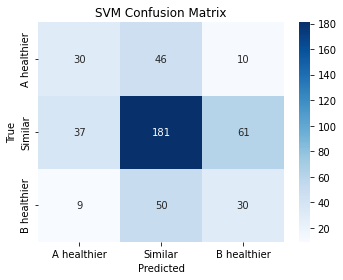

In [44]:
# make working copy
df_d = diffs.dropna(subset=["d_SRH"]).copy()

# 3-class coding for health difference
delta = 1
df_d["y_3"] = np.where(df_d["d_SRH"] > delta, 1,
                np.where(df_d["d_SRH"] < -delta, -1, 0)).astype(int)

# features 
X_cols = [c for c in df_d.columns if c.startswith("d_") and c != "d_SRH"]
X = df_d[X_cols].copy()
y = df_d["y_3"].copy()

# class counts
print("class counts (-1,0,+1):", dict(y.value_counts().sort_index()))

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# impute missing values with median 
imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

# standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)

# SVM model 
model = SVC(kernel="rbf", C=2.0, gamma="scale", class_weight="balanced", random_state=42)
model.fit(X_train_scaled, y_train)

# predictions
y_pred = model.predict(X_test_scaled)

# metrics
print("accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("f1:", round(f1_score(y_test, y_pred, average="macro"), 3))
print("\nconfusion matrix:\n", confusion_matrix(y_test, y_pred, labels=[-1,0,1]))
print("\nclassification report:\n", classification_report(y_test, y_pred, labels=[-1,0,1], digits=3))

# cross-validation 
y_bin = (y != 0).astype(int)
pipe_cv = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
    ("svm", SVC(kernel="rbf", C=2.0, gamma="scale", class_weight="balanced", random_state=42))
])
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_acc = cross_val_score(pipe_cv, X, y_bin, cv=skf, scoring="accuracy")
cv_f1  = cross_val_score(pipe_cv, X, y_bin, cv=skf, scoring="f1")
print("\ncv accuracy (mean±sd): {:.3f} ± {:.3f}".format(cv_acc.mean(), cv_acc.std()))
print("cv f1 (mean±sd): {:.3f} ± {:.3f}".format(cv_f1.mean(), cv_f1.std()))

# class distribution in test set
print(pd.Series(y_test).value_counts(normalize=True).rename(
    index={-1:"A healthier", 0:"Similar", 1:"B healthier"}).round(3))

# confusion matrix plot
cm = confusion_matrix(y_test, y_pred, labels=[-1, 0, 1])
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["A healthier", "Similar", "B healthier"],
            yticklabels=["A healthier", "Similar", "B healthier"])
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

### Logistic Regression

X shape: (3026, 13)
class balance: {1: 2691, 0: 335}
accuracy: 0.725
balanced accuracy: 0.726
f1: 0.824
roc-auc: 0.782

confusion matrix:
 [[ 61  23]
 [185 488]]

classification report:
               precision    recall  f1-score   support

           0      0.248     0.726     0.370        84
           1      0.955     0.725     0.824       673

    accuracy                          0.725       757
   macro avg      0.601     0.726     0.597       757
weighted avg      0.877     0.725     0.774       757



,feature,coef
5,EDUC,0.285309
3,DEPRESS,0.224839
2,ASTHMA,0.197092
1,DIABETES,0.173676
9,EXERCISE,0.152002
7,SMOKING,0.068360
6,HHINCOME,0.036161
0,HYPERTEN,0.008337
8,ALCOHOL,-0.049849
10,MARITAL,-0.132059


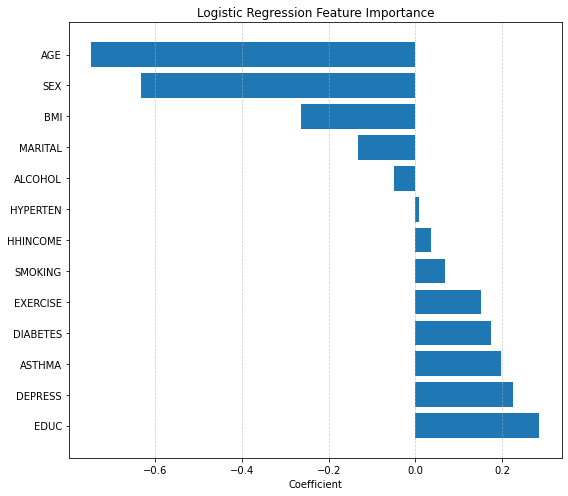


cv accuracy (mean±sd): 0.737 ± 0.014
cv balanced accuracy (mean±sd): 0.698 ± 0.031
cv f1 (mean±sd): 0.835 ± 0.009
cv roc-auc (mean±sd): 0.763 ± 0.030


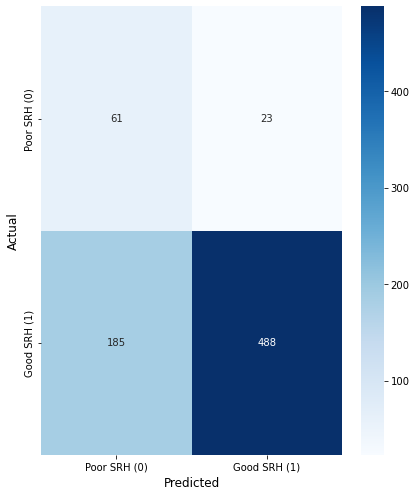

In [48]:
# working copy
df_l = long.copy()

# ensure SRH is numeric
df_l["SRH"] = pd.to_numeric(df_l["SRH"], errors="coerce")

# create binary target for SRH
# 1 = good SRH(SRH >= 6)
# 0 = poor SRH (SRH <= 5)
df_l["SRH_binary"] = np.where(df_l["SRH"] >= 6, 1, np.where(df_l["SRH"] <= 5, 0, np.nan))

# drop rows with missing target
df_l = df_l.dropna(subset=["SRH_binary"]).copy()
y = df_l["SRH_binary"].astype(int)

# drop SRH, SRH_binary, and identifiers from features
drop_cols = ["M2ID", "M2FAMNUM", "wave", "SAMPLMAJ", "ZYGCAT", "SRH", "SRH_binary"]
X = df_l.drop(columns=[c for c in drop_cols if c in df_l.columns], errors="ignore")

# define X as numeric only features
X = X.select_dtypes(include=[np.number])

# print shape and class balance
print("X shape:", X.shape)
print("class balance:", dict(y.value_counts()))

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# impute missing values with median
imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

# standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)

# initialize logistic regression with elastic-net
logreg = LogisticRegression(
    penalty="elasticnet",
    solver="saga",
    l1_ratio=0.5,
    class_weight="balanced",
    max_iter=5000,
    random_state=42
)

# fit model
logreg.fit(X_train_scaled, y_train)

# predict
y_pred = logreg.predict(X_test_scaled)
y_prob = logreg.predict_proba(X_test_scaled)[:, 1]

# metrics
print("accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("balanced accuracy:", round(balanced_accuracy_score(y_test, y_pred), 3))
print("f1:", round(f1_score(y_test, y_pred), 3))
print("roc-auc:", round(roc_auc_score(y_test, y_prob), 3))
print("\nconfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nclassification report:\n", classification_report(y_test, y_pred, digits=3))

# coefficients (scaled)
coef_df = pd.DataFrame({"feature": X.columns, "coef": logreg.coef_.ravel()}).sort_values(
    "coef", ascending=False)
display(coef_df.head(10))

# bar plot of coefficients
plt.figure(figsize=(8,7))
plt.barh(coef_df["feature"], coef_df["coef"])
plt.grid(axis="x", linestyle="--", linewidth=0.7, alpha=0.7)
plt.title("Logistic Regression Feature Importance")
plt.xlabel("Coefficient")
plt.tight_layout()
plt.show()

# log reg pipeline
pipe_cv = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
    ("logit", LogisticRegression(
        penalty="elasticnet",
        solver="saga",
        l1_ratio=0.5,
        class_weight="balanced",
        max_iter=5000,
        random_state=42
    ))
])

# cross validation 
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_acc = cross_val_score(pipe_cv, X, y, cv=skf, scoring="accuracy")
cv_bal = cross_val_score(pipe_cv, X, y, cv=skf, scoring="balanced_accuracy")
cv_f1 = cross_val_score(pipe_cv, X, y, cv=skf, scoring="f1")
cv_auc = cross_val_score(pipe_cv, X, y, cv=skf, scoring="roc_auc")
print("\ncv accuracy (mean±sd): {:.3f} ± {:.3f}".format(cv_acc.mean(), cv_acc.std()))
print("cv balanced accuracy (mean±sd): {:.3f} ± {:.3f}".format(cv_bal.mean(), cv_bal.std()))
print("cv f1 (mean±sd): {:.3f} ± {:.3f}".format(cv_f1.mean(), cv_f1.std()))
print("cv roc-auc (mean±sd): {:.3f} ± {:.3f}".format(cv_auc.mean(), cv_auc.std()))

# compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ["Poor SRH (0)", "Good SRH (1)"]
plt.figure(figsize=(6,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.tight_layout()
plt.show()

### Gradient Boosted Decision Trees

X shape: (3026, 13)
class balance: {1: 2691, 0: 335}
accuracy: 0.785
balanced accuracy: 0.686
f1: 0.87
roc-auc: 0.753

confusion matrix:
 [[ 47  37]
 [126 547]]

classification report:
               precision    recall  f1-score   support

           0      0.272     0.560     0.366        84
           1      0.937     0.813     0.870       673

    accuracy                          0.785       757
   macro avg      0.604     0.686     0.618       757
weighted avg      0.863     0.785     0.814       757



,feature,importance
4,BMI,0.345640
11,AGE,0.227135
5,EDUC,0.089202
8,ALCOHOL,0.082395
6,HHINCOME,0.070331
10,MARITAL,0.045873
3,DEPRESS,0.035990
9,EXERCISE,0.030031
2,ASTHMA,0.024845
1,DIABETES,0.020130


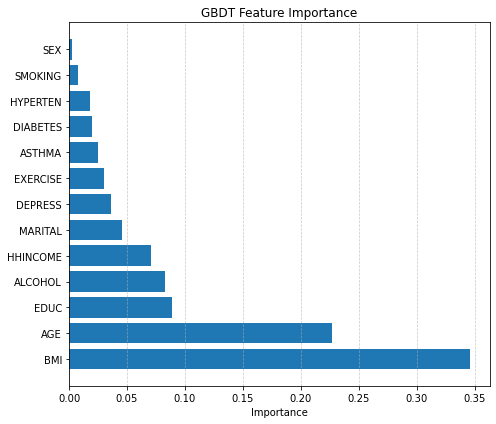


cv accuracy (mean±sd): 0.891 ± 0.006
cv balanced acc (mean±sd): 0.575 ± 0.023
cv f1 (mean±sd): 0.941 ± 0.003
cv roc-auc (mean±sd): 0.769 ± 0.030


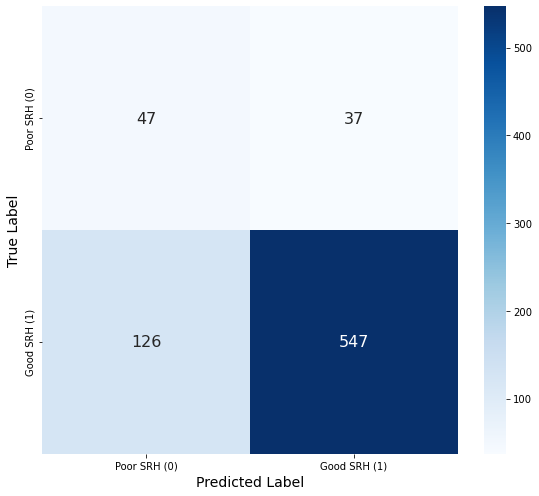

In [50]:
# working copy
df_l = long.copy()

# ensure SRH is numeric
df_l["SRH"] = pd.to_numeric(df_l["SRH"], errors="coerce")

# create binary target for SRH
# 1 = good SRH(SRH >= 6)
# 0 = poor SRH (SRH <= 5)
df_l["SRH_binary"] = np.where(df_l["SRH"] >= 6, 1, np.where(df_l["SRH"] <= 5, 0, np.nan))

# drop rows with missing target
df_l = df_l.dropna(subset=["SRH_binary"]).copy()
y = df_l["SRH_binary"].astype(int)

# drop SRH, SRH_binary, and identifiers from features
drop_cols = ["M2ID", "M2FAMNUM", "wave", "SAMPLMAJ", "ZYGCAT", "SRH", "SRH_binary"]
X = df_l.drop(columns=[c for c in drop_cols if c in df_l.columns], errors="ignore")

# define X as numeric only features
X = X.select_dtypes(include=[np.number])

# print shape and class balance
print("X shape:", X.shape)
print("class balance:", dict(y.value_counts()))

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# impute missing values with median  
imp = SimpleImputer(strategy="median")
X_train_imp = imp.fit_transform(X_train)
X_test_imp  = imp.transform(X_test)

# compute sample weights for imbalance
class_counts = y_train.value_counts().to_dict()
w = {c: (len(y_train) / (2.0 * class_counts[c])) for c in class_counts}  
sample_weight = np.array([w[c] for c in y_train])

# initialize gradient boosted trees 
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05, 
    max_depth=3,
    subsample=0.8,
    random_state=42
)

# fit model
gb.fit(X_train_imp, y_train, sample_weight=sample_weight)

# predict
y_pred = gb.predict(X_test_imp)
y_prob = gb.predict_proba(X_test_imp)[:, 1]

# metrics
print("accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("balanced accuracy:", round(balanced_accuracy_score(y_test, y_pred), 3))
print("f1:", round(f1_score(y_test, y_pred), 3))
print("roc-auc:", round(roc_auc_score(y_test, y_prob), 3))
print("\nconfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nclassification report:\n", classification_report(y_test, y_pred, digits=3))

# feature importances 
fi = pd.DataFrame({"feature": X.columns, "importance": gb.feature_importances_}).sort_values("importance", ascending=False)
display(fi.head(12))

# plot for feature importance
plt.figure(figsize=(7,6))
plt.barh(fi["feature"], fi["importance"])
plt.grid(axis="x", linestyle="--", linewidth=0.7, alpha=0.7)
plt.title("GBDT Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# pipe for cross validation
pipe_cv = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("gb", GradientBoostingClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=3, subsample=0.8, random_state=42
    ))
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_acc = cross_val_score(pipe_cv, X, y, cv=skf, scoring="accuracy")
cv_bal = cross_val_score(pipe_cv, X, y, cv=skf, scoring="balanced_accuracy")
cv_f1  = cross_val_score(pipe_cv, X, y, cv=skf, scoring="f1")
cv_auc = cross_val_score(pipe_cv, X, y, cv=skf, scoring="roc_auc")
print("\ncv accuracy (mean±sd): {:.3f} ± {:.3f}".format(cv_acc.mean(), cv_acc.std()))
print("cv balanced acc (mean±sd): {:.3f} ± {:.3f}".format(cv_bal.mean(), cv_bal.std()))
print("cv f1 (mean±sd): {:.3f} ± {:.3f}".format(cv_f1.mean(), cv_f1.std()))
print("cv roc-auc (mean±sd): {:.3f} ± {:.3f}".format(cv_auc.mean(), cv_auc.std()))

# compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Poor SRH (0)', 'Good SRH (1)']
plt.figure(figsize=(8,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            annot_kws={"size":16})
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.tight_layout()
plt.show()